In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries loaded")

✅ Libraries loaded


## 1. Load RSSI Data

In [2]:
# Load all RSSI parquet files
rssi_dir = Path('data/RSSI')
parquet_files = sorted(rssi_dir.glob('*_RSSI_*.parquet'))

print(f"Found {len(parquet_files)} RSSI files")
print(f"\nLoading data...")

all_data = []
for file_path in tqdm(parquet_files[:10]):  # Start with first 10 for speed
    receiver_id = file_path.stem.split('_')[0]
    df = pd.read_parquet(file_path)
    df = df.rename(columns={'accelero_id': 'emitter_id'})
    df['receiver_id'] = receiver_id
    df = df[['receiver_id', 'emitter_id', 'RSSI', 'relative_DateTime']]
    all_data.append(df)

rssi_df = pd.concat(all_data, ignore_index=True)
rssi_df['relative_DateTime'] = pd.to_datetime(rssi_df['relative_DateTime'])

print(f"\n✅ Loaded {len(rssi_df):,} RSSI measurements")
print(f"   Time range: {rssi_df['relative_DateTime'].min()} to {rssi_df['relative_DateTime'].max()}")
print(f"   Duration: {(rssi_df['relative_DateTime'].max() - rssi_df['relative_DateTime'].min()).days} days")
print(f"   Unique receivers: {rssi_df['receiver_id'].nunique()}")
print(f"   Unique emitters: {rssi_df['emitter_id'].nunique()}")

Found 47 RSSI files

Loading data...


100%|██████████| 10/10 [00:00<00:00, 23.57it/s]



✅ Loaded 2,782,596 RSSI measurements
   Time range: 2025-03-17 00:00:00.062500 to 2025-03-23 23:59:58.750000
   Duration: 6 days
   Unique receivers: 10
   Unique emitters: 49


In [3]:
# Display sample
rssi_df.head(10)

,receiver_id,emitter_id,RSSI,relative_DateTime
0,365d,3cf2,-45,2025-03-17 00:01:01.000000
1,365d,3665,-43,2025-03-17 00:01:01.000000
2,365d,3d05,-64,2025-03-17 00:01:01.125000
3,365d,3d09,-55,2025-03-17 00:01:01.125000
4,365d,366b,-66,2025-03-17 00:01:01.125000
5,365d,366d,-61,2025-03-17 00:01:01.125000
6,365d,3ced,-60,2025-03-17 00:01:01.187500
7,365d,3664,-50,2025-03-17 00:01:01.250000
8,365d,3d0c,-58,2025-03-17 00:01:01.250000
9,365d,3667,-55,2025-03-17 00:01:01.250000


## 2. RSSI Distribution Analysis

In [4]:
# Basic statistics
print("RSSI Statistics:")
print(rssi_df['RSSI'].describe())
print(f"\nRSSI range: {rssi_df['RSSI'].min():.1f} to {rssi_df['RSSI'].max():.1f} dBm")

RSSI Statistics:
count    2.782596e+06
mean    -7.083635e+01
std      1.404108e+01
min     -9.200000e+01
25%     -8.000000e+01
50%     -7.700000e+01
75%     -6.200000e+01
max     -2.600000e+01
Name: RSSI, dtype: float64

RSSI range: -92.0 to -26.0 dBm


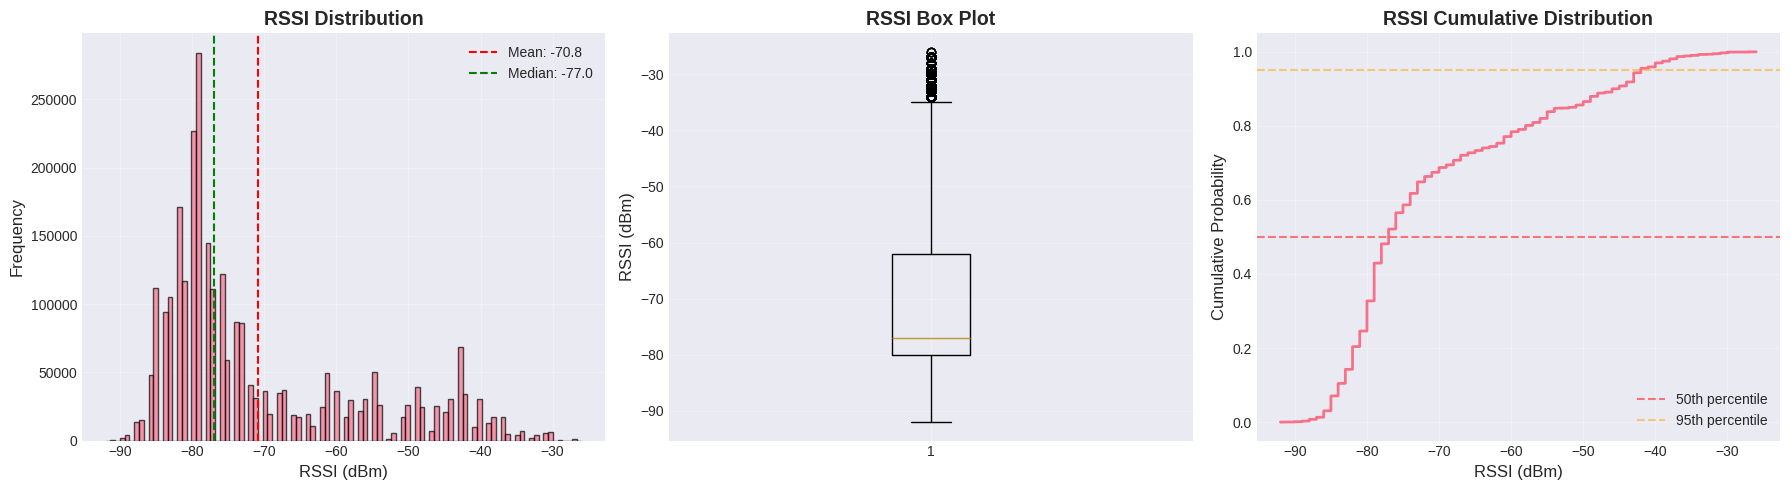


Percentage of measurements above common thresholds:
  RSSI >= -100 dBm: 100.00%
  RSSI >= -90 dBm: 99.97%
  RSSI >= -80 dBm: 75.43%
  RSSI >= -70 dBm: 32.55%
  RSSI >= -60 dBm: 22.90%


In [5]:
# RSSI distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(rssi_df['RSSI'], bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(rssi_df['RSSI'].mean(), color='red', linestyle='--', label=f'Mean: {rssi_df["RSSI"].mean():.1f}')
axes[0].axvline(rssi_df['RSSI'].median(), color='green', linestyle='--', label=f'Median: {rssi_df["RSSI"].median():.1f}')
axes[0].set_xlabel('RSSI (dBm)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('RSSI Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(rssi_df['RSSI'], vert=True)
axes[1].set_ylabel('RSSI (dBm)', fontsize=12)
axes[1].set_title('RSSI Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Cumulative distribution
sorted_rssi = np.sort(rssi_df['RSSI'])
cumulative = np.arange(1, len(sorted_rssi) + 1) / len(sorted_rssi)
axes[2].plot(sorted_rssi, cumulative, linewidth=2)
axes[2].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='50th percentile')
axes[2].axhline(0.95, color='orange', linestyle='--', alpha=0.5, label='95th percentile')
axes[2].set_xlabel('RSSI (dBm)', fontsize=12)
axes[2].set_ylabel('Cumulative Probability', fontsize=12)
axes[2].set_title('RSSI Cumulative Distribution', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# RSSI thresholds commonly used
thresholds = [-100, -90, -80, -70, -60]
print("\nPercentage of measurements above common thresholds:")
for thresh in thresholds:
    pct = (rssi_df['RSSI'] >= thresh).mean() * 100
    print(f"  RSSI >= {thresh} dBm: {pct:.2f}%")

## 3. Temporal Patterns

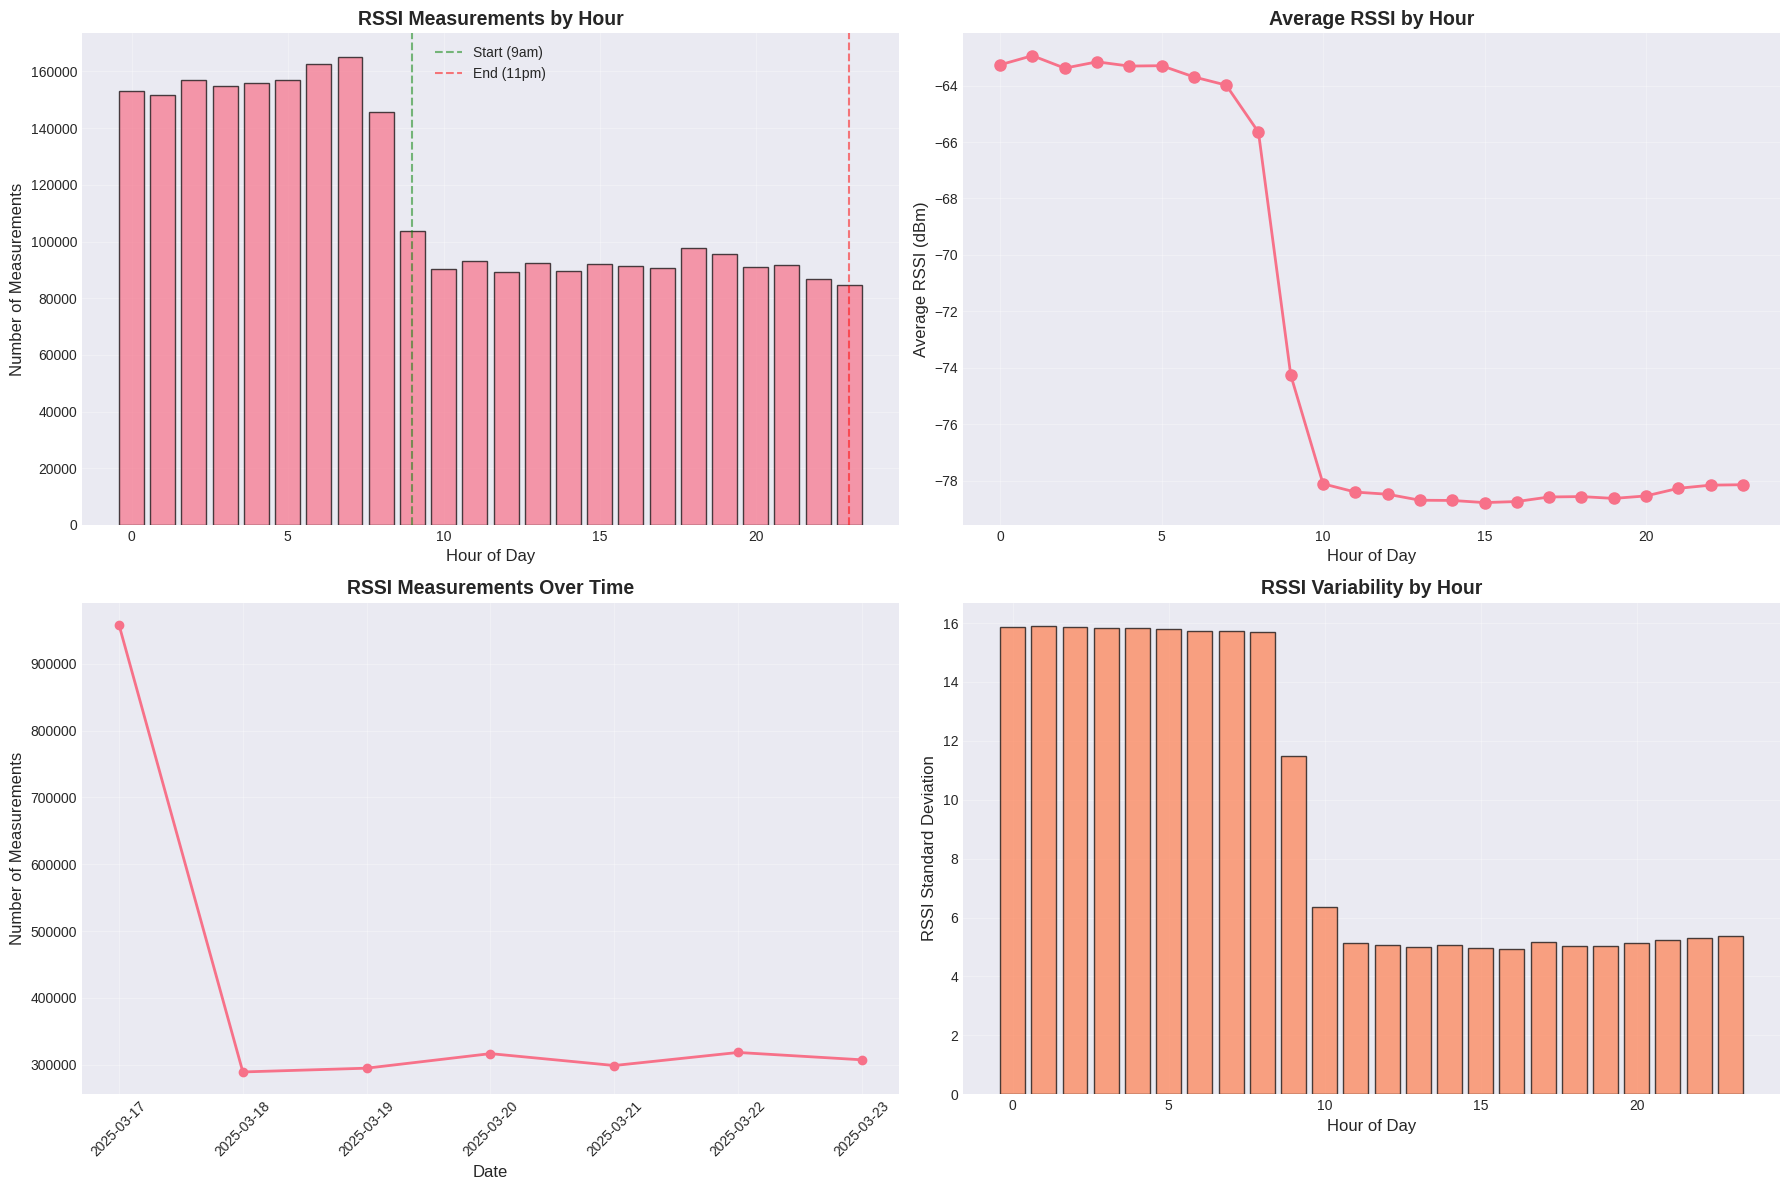

In [6]:
# Add temporal features
rssi_df['hour'] = rssi_df['relative_DateTime'].dt.hour
rssi_df['date'] = rssi_df['relative_DateTime'].dt.date
rssi_df['day_of_week'] = rssi_df['relative_DateTime'].dt.day_name()

# Measurements over time
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Measurements by hour
hourly_counts = rssi_df.groupby('hour').size()
axes[0, 0].bar(hourly_counts.index, hourly_counts.values, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Hour of Day', fontsize=12)
axes[0, 0].set_ylabel('Number of Measurements', fontsize=12)
axes[0, 0].set_title('RSSI Measurements by Hour', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(9, color='green', linestyle='--', alpha=0.5, label='Start (9am)')
axes[0, 0].axvline(23, color='red', linestyle='--', alpha=0.5, label='End (11pm)')
axes[0, 0].legend()

# Average RSSI by hour
hourly_rssi = rssi_df.groupby('hour')['RSSI'].mean()
axes[0, 1].plot(hourly_rssi.index, hourly_rssi.values, marker='o', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Hour of Day', fontsize=12)
axes[0, 1].set_ylabel('Average RSSI (dBm)', fontsize=12)
axes[0, 1].set_title('Average RSSI by Hour', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Measurements by date
daily_counts = rssi_df.groupby('date').size()
axes[1, 0].plot(daily_counts.index, daily_counts.values, marker='o', linewidth=2)
axes[1, 0].set_xlabel('Date', fontsize=12)
axes[1, 0].set_ylabel('Number of Measurements', fontsize=12)
axes[1, 0].set_title('RSSI Measurements Over Time', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# RSSI variability by hour
hourly_std = rssi_df.groupby('hour')['RSSI'].std()
axes[1, 1].bar(hourly_std.index, hourly_std.values, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].set_xlabel('Hour of Day', fontsize=12)
axes[1, 1].set_ylabel('RSSI Standard Deviation', fontsize=12)
axes[1, 1].set_title('RSSI Variability by Hour', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Cow Interaction Patterns

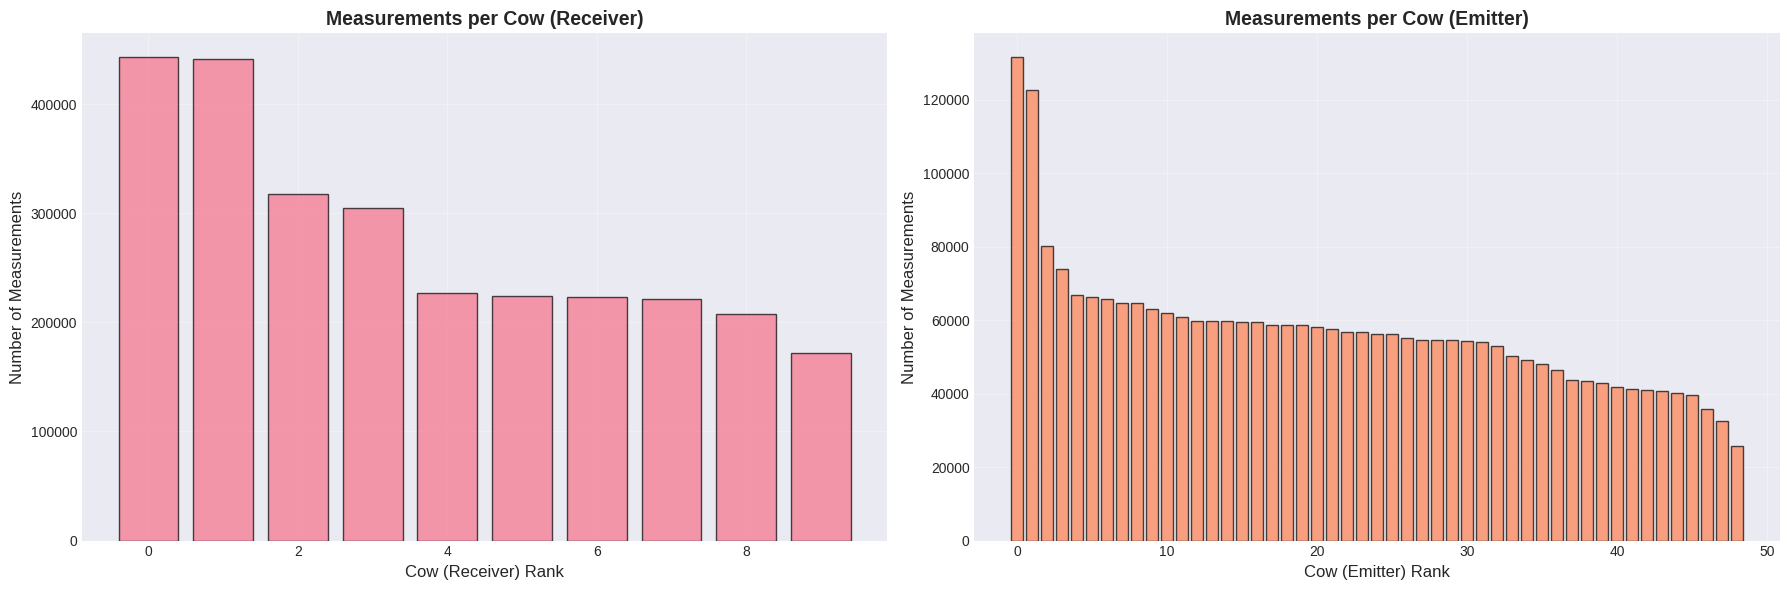


Receiver Statistics:
  Mean measurements per cow: 278260
  Min: 171493, Max: 442776

Emitter Statistics:
  Mean measurements per cow: 56788
  Min: 25864, Max: 131555


In [7]:
# Measurements per cow (receiver)
receiver_counts = rssi_df['receiver_id'].value_counts()
emitter_counts = rssi_df['emitter_id'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Receiver distribution
axes[0].bar(range(len(receiver_counts)), receiver_counts.values, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Cow (Receiver) Rank', fontsize=12)
axes[0].set_ylabel('Number of Measurements', fontsize=12)
axes[0].set_title('Measurements per Cow (Receiver)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Emitter distribution
axes[1].bar(range(len(emitter_counts)), emitter_counts.values, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Cow (Emitter) Rank', fontsize=12)
axes[1].set_ylabel('Number of Measurements', fontsize=12)
axes[1].set_title('Measurements per Cow (Emitter)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nReceiver Statistics:")
print(f"  Mean measurements per cow: {receiver_counts.mean():.0f}")
print(f"  Min: {receiver_counts.min()}, Max: {receiver_counts.max()}")
print(f"\nEmitter Statistics:")
print(f"  Mean measurements per cow: {emitter_counts.mean():.0f}")
print(f"  Min: {emitter_counts.min()}, Max: {emitter_counts.max()}")

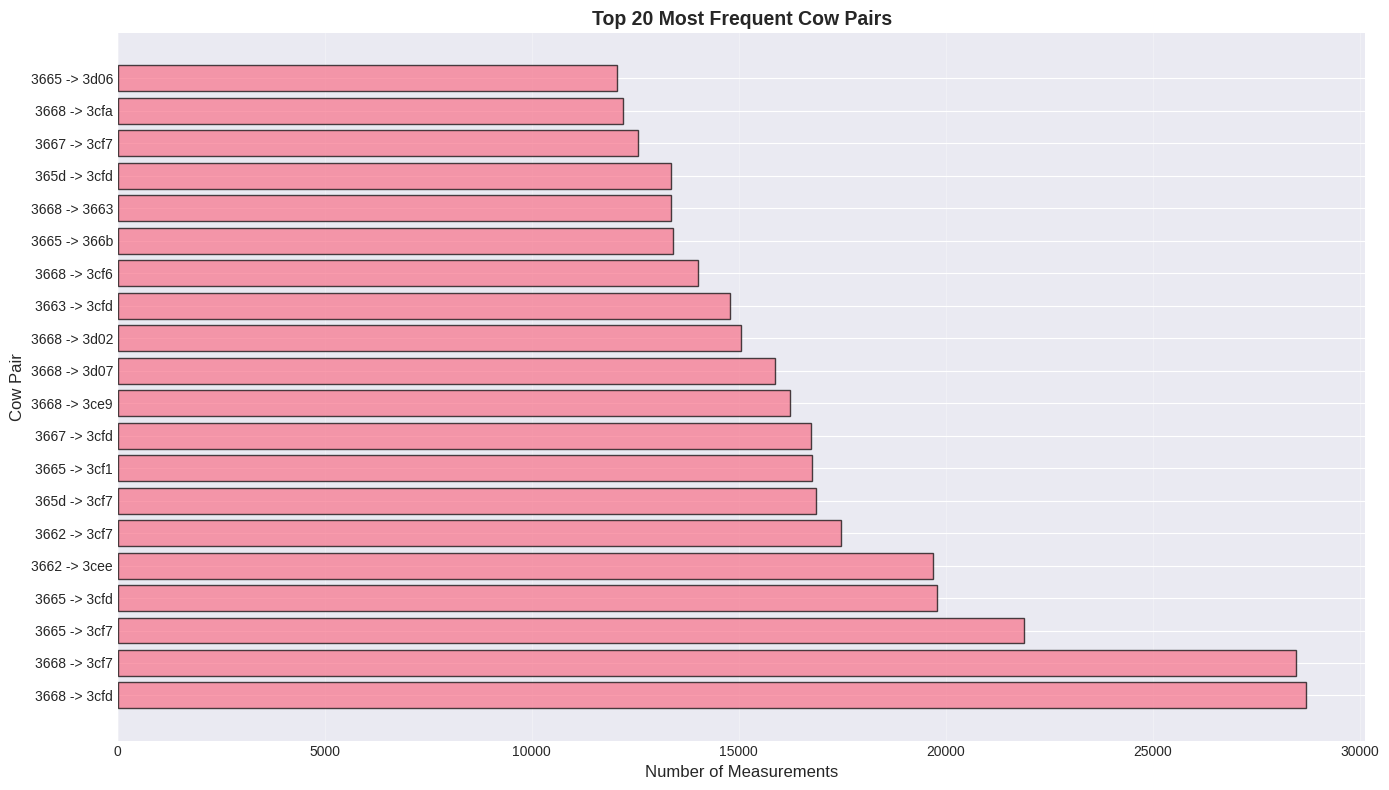


Total unique cow pairs: 480
Top pair: 3668 -> 3cfd with 28,698 measurements


In [8]:
# Cow pair interactions (most frequent pairs)
rssi_df['pair'] = rssi_df['receiver_id'] + ' -> ' + rssi_df['emitter_id']
pair_counts = rssi_df['pair'].value_counts().head(20)

plt.figure(figsize=(14, 8))
plt.barh(range(len(pair_counts)), pair_counts.values, edgecolor='black', alpha=0.7)
plt.yticks(range(len(pair_counts)), pair_counts.index)
plt.xlabel('Number of Measurements', fontsize=12)
plt.ylabel('Cow Pair', fontsize=12)
plt.title('Top 20 Most Frequent Cow Pairs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\nTotal unique cow pairs: {rssi_df['pair'].nunique():,}")
print(f"Top pair: {pair_counts.index[0]} with {pair_counts.values[0]:,} measurements")

## 5. Proximity Graph Construction

In [9]:
# Create proximity graphs at different RSSI thresholds
def create_proximity_graph(df, rssi_threshold=-70, time_window='1H'):
    """
    Create a proximity graph based on RSSI threshold.
    """
    # Filter by RSSI threshold
    df_filtered = df[df['RSSI'] >= rssi_threshold].copy()
    
    # Aggregate over time window
    df_filtered['time_bin'] = df_filtered['relative_DateTime'].dt.floor(time_window)
    
    # Count interactions
    interactions = df_filtered.groupby(['receiver_id', 'emitter_id']).size().reset_index(name='count')
    
    # Create graph
    G = nx.Graph()
    for _, row in interactions.iterrows():
        G.add_edge(row['receiver_id'], row['emitter_id'], weight=row['count'])
    
    return G, interactions

# Test different thresholds
thresholds = [-100, -80, -70, -60]
graphs = {}
stats = []

for thresh in thresholds:
    G, interactions = create_proximity_graph(rssi_df, rssi_threshold=thresh)
    graphs[thresh] = G
    
    stats.append({
        'threshold': thresh,
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes() if G.number_of_nodes() > 0 else 0
    })

stats_df = pd.DataFrame(stats)
print("\nProximity Graph Statistics at Different RSSI Thresholds:")
print(stats_df.to_string(index=False))


Proximity Graph Statistics at Different RSSI Thresholds:
 threshold  nodes  edges  density  avg_degree
      -100     49    435 0.369898   17.755102
       -80     49    435 0.369898   17.755102
       -70     49    435 0.369898   17.755102
       -60     49    432 0.367347   17.632653


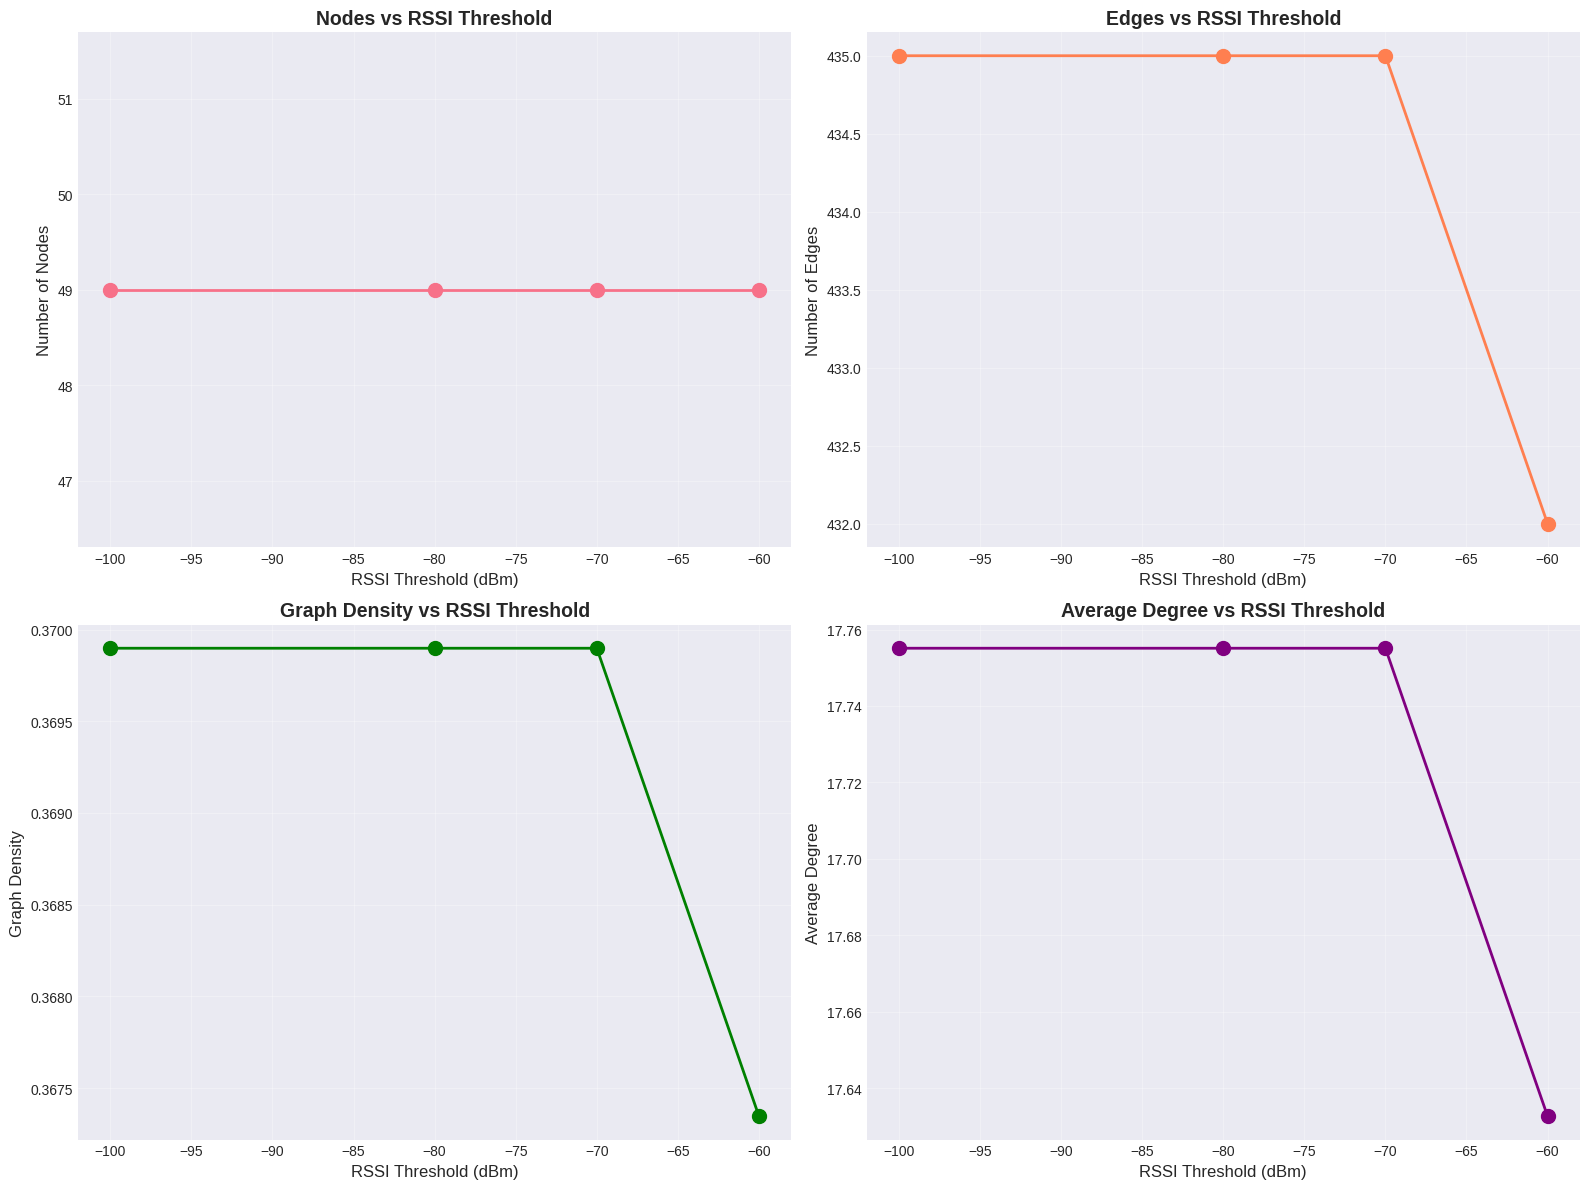

In [10]:
# Visualize graph statistics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Number of nodes
axes[0, 0].plot(stats_df['threshold'], stats_df['nodes'], marker='o', linewidth=2, markersize=10)
axes[0, 0].set_xlabel('RSSI Threshold (dBm)', fontsize=12)
axes[0, 0].set_ylabel('Number of Nodes', fontsize=12)
axes[0, 0].set_title('Nodes vs RSSI Threshold', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Number of edges
axes[0, 1].plot(stats_df['threshold'], stats_df['edges'], marker='o', linewidth=2, markersize=10, color='coral')
axes[0, 1].set_xlabel('RSSI Threshold (dBm)', fontsize=12)
axes[0, 1].set_ylabel('Number of Edges', fontsize=12)
axes[0, 1].set_title('Edges vs RSSI Threshold', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Graph density
axes[1, 0].plot(stats_df['threshold'], stats_df['density'], marker='o', linewidth=2, markersize=10, color='green')
axes[1, 0].set_xlabel('RSSI Threshold (dBm)', fontsize=12)
axes[1, 0].set_ylabel('Graph Density', fontsize=12)
axes[1, 0].set_title('Graph Density vs RSSI Threshold', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Average degree
axes[1, 1].plot(stats_df['threshold'], stats_df['avg_degree'], marker='o', linewidth=2, markersize=10, color='purple')
axes[1, 1].set_xlabel('RSSI Threshold (dBm)', fontsize=12)
axes[1, 1].set_ylabel('Average Degree', fontsize=12)
axes[1, 1].set_title('Average Degree vs RSSI Threshold', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Network Analysis (RSSI = -70 dBm)

Analyzing graph at RSSI >= -70 dBm
  Nodes: 49
  Edges: 435
  Density: 0.3699
  Average clustering: 0.8659


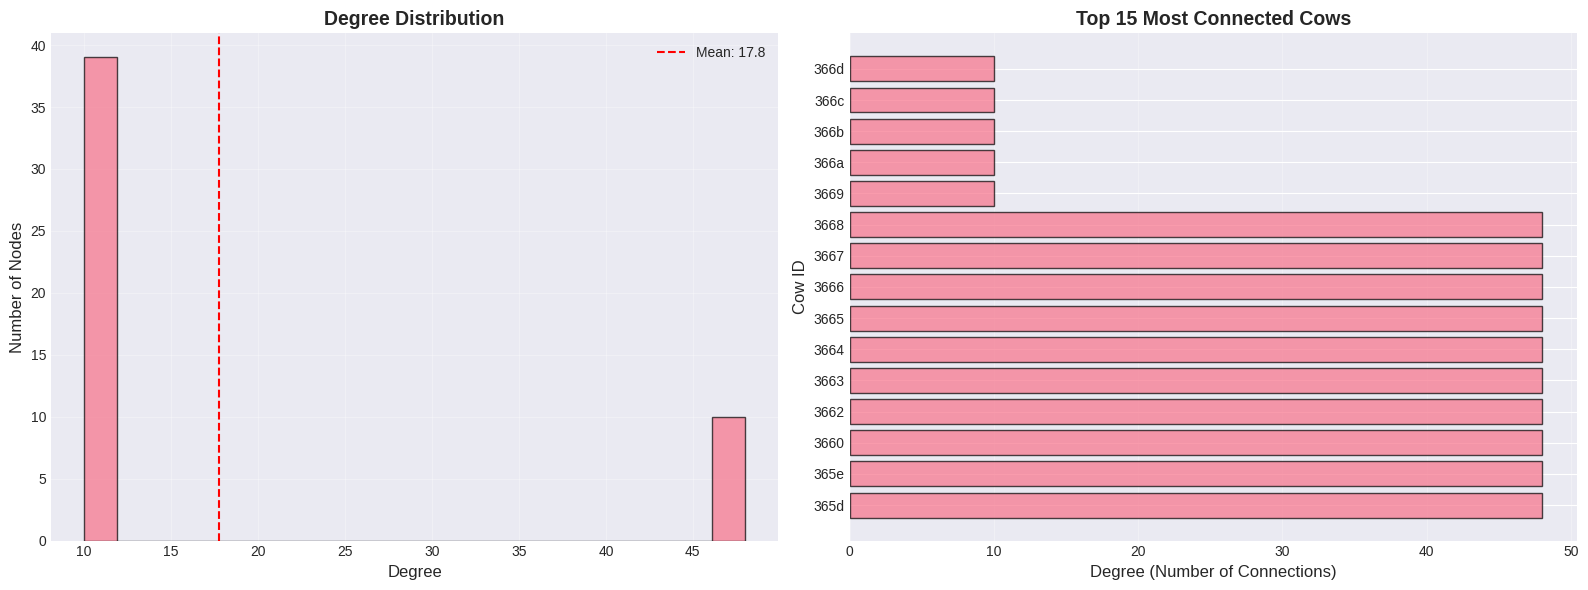

In [11]:
# Use graph at -70 dBm threshold (common choice)
G = graphs[-70]

print(f"Analyzing graph at RSSI >= -70 dBm")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Density: {nx.density(G):.4f}")
print(f"  Average clustering: {nx.average_clustering(G):.4f}")

# Degree distribution
degrees = dict(G.degree())
degree_values = list(degrees.values())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Degree histogram
axes[0].hist(degree_values, bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(degree_values), color='red', linestyle='--', label=f'Mean: {np.mean(degree_values):.1f}')
axes[0].set_xlabel('Degree', fontsize=12)
axes[0].set_ylabel('Number of Nodes', fontsize=12)
axes[0].set_title('Degree Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Top connected cows
top_cows = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:15]
cows, degs = zip(*top_cows)
axes[1].barh(range(len(cows)), degs, edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(cows)))
axes[1].set_yticklabels(cows)
axes[1].set_xlabel('Degree (Number of Connections)', fontsize=12)
axes[1].set_ylabel('Cow ID', fontsize=12)
axes[1].set_title('Top 15 Most Connected Cows', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

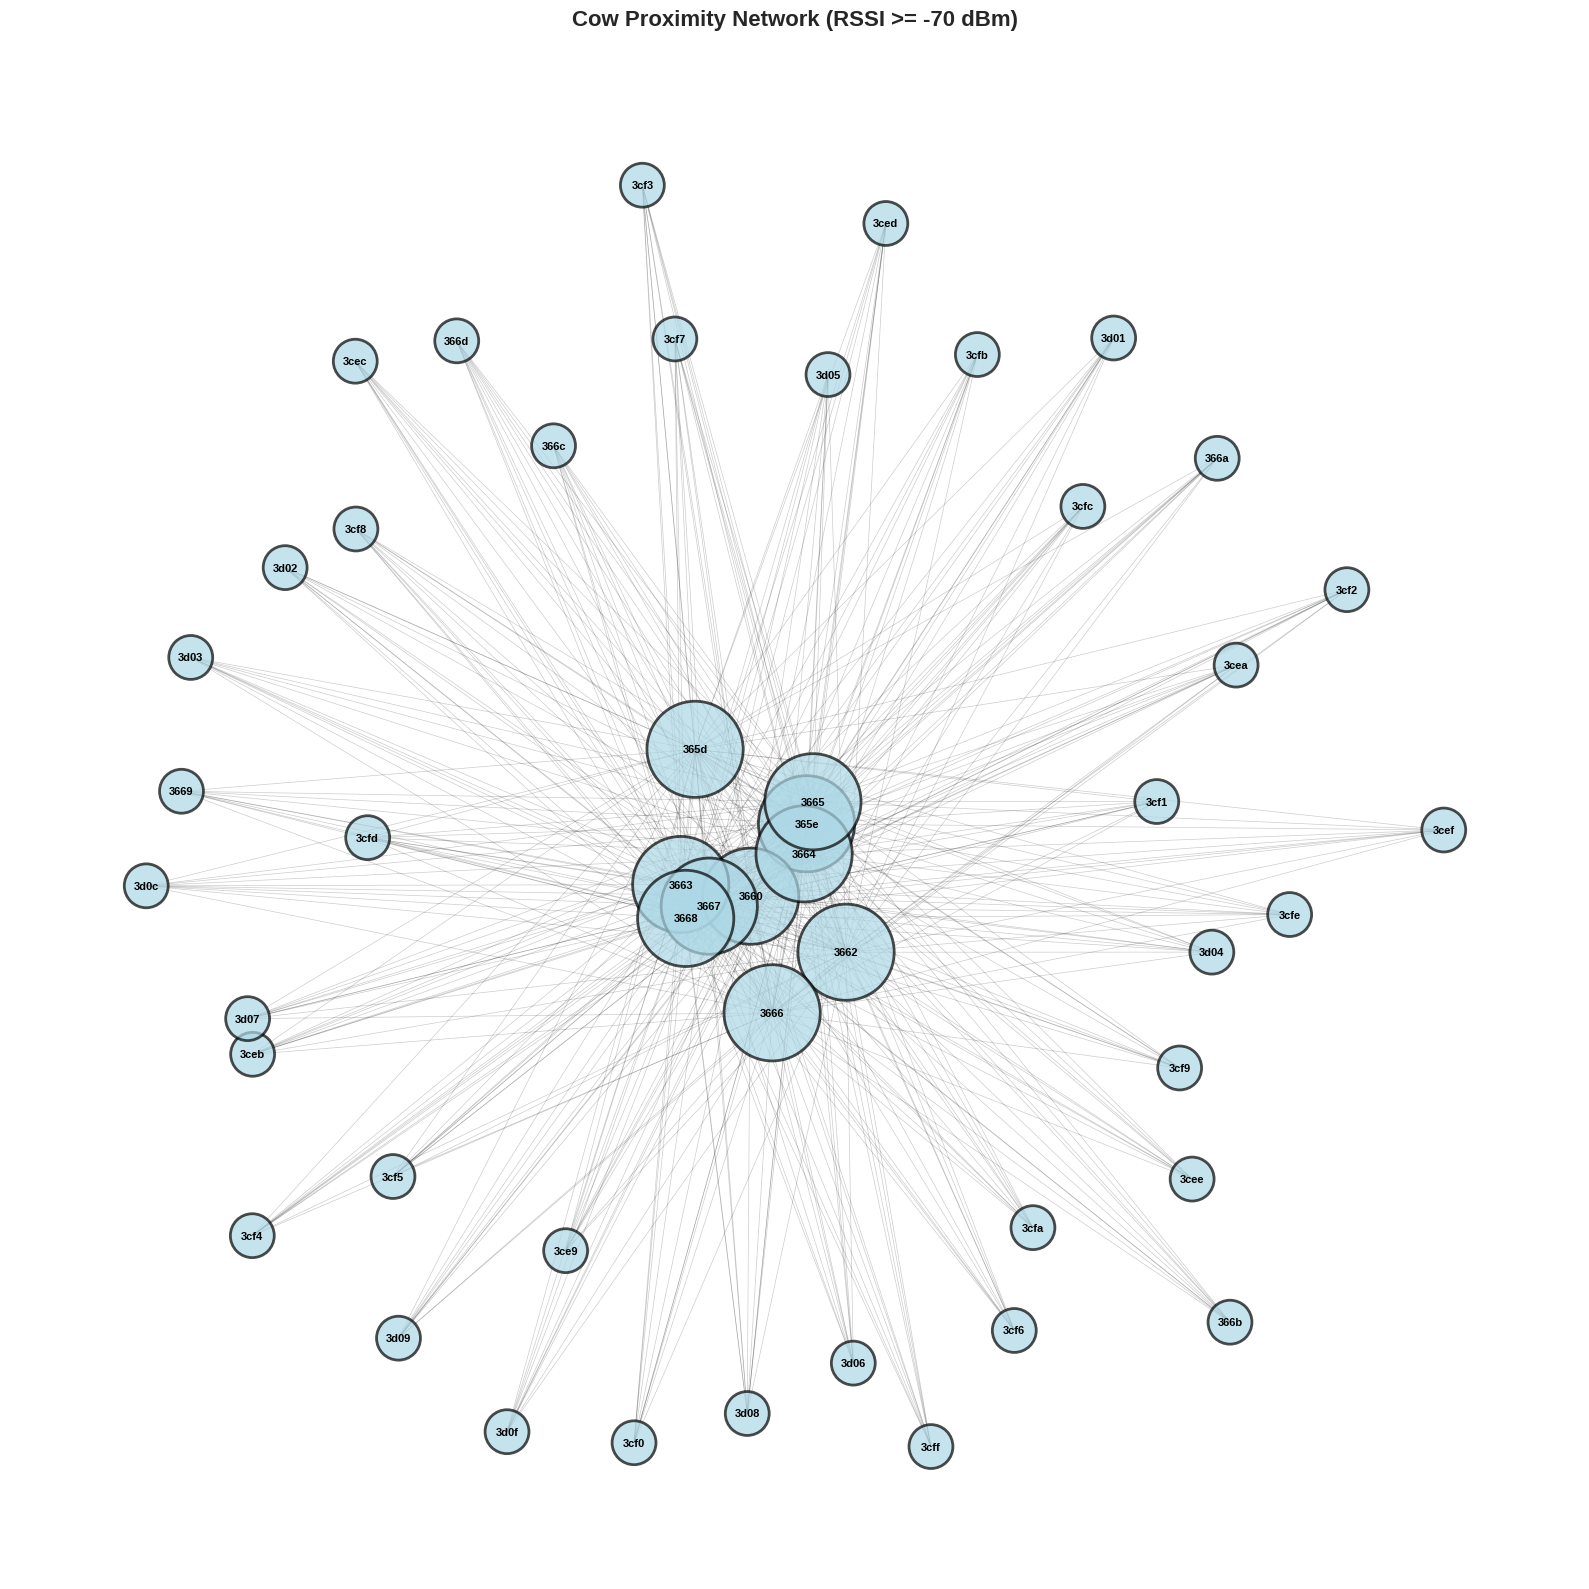

Note: Node size represents degree (number of connections)


In [12]:
# Visualize the network
plt.figure(figsize=(16, 16))

# Calculate node sizes based on degree
node_sizes = [degrees[node] * 100 for node in G.nodes()]

# Use spring layout
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Draw
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', 
                       edgecolors='black', linewidths=2, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title('Cow Proximity Network (RSSI >= -70 dBm)', fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print("Note: Node size represents degree (number of connections)")

## 7. Community Detection

In [13]:
# Detect communities using Louvain algorithm
from networkx.algorithms import community

# Find communities
communities = community.greedy_modularity_communities(G)

print(f"Number of communities detected: {len(communities)}")
print(f"\nCommunity sizes:")
for i, comm in enumerate(communities):
    print(f"  Community {i+1}: {len(comm)} cows")
    if len(comm) <= 10:
        print(f"    Members: {', '.join(sorted(comm))}")

Number of communities detected: 1

Community sizes:
  Community 1: 49 cows


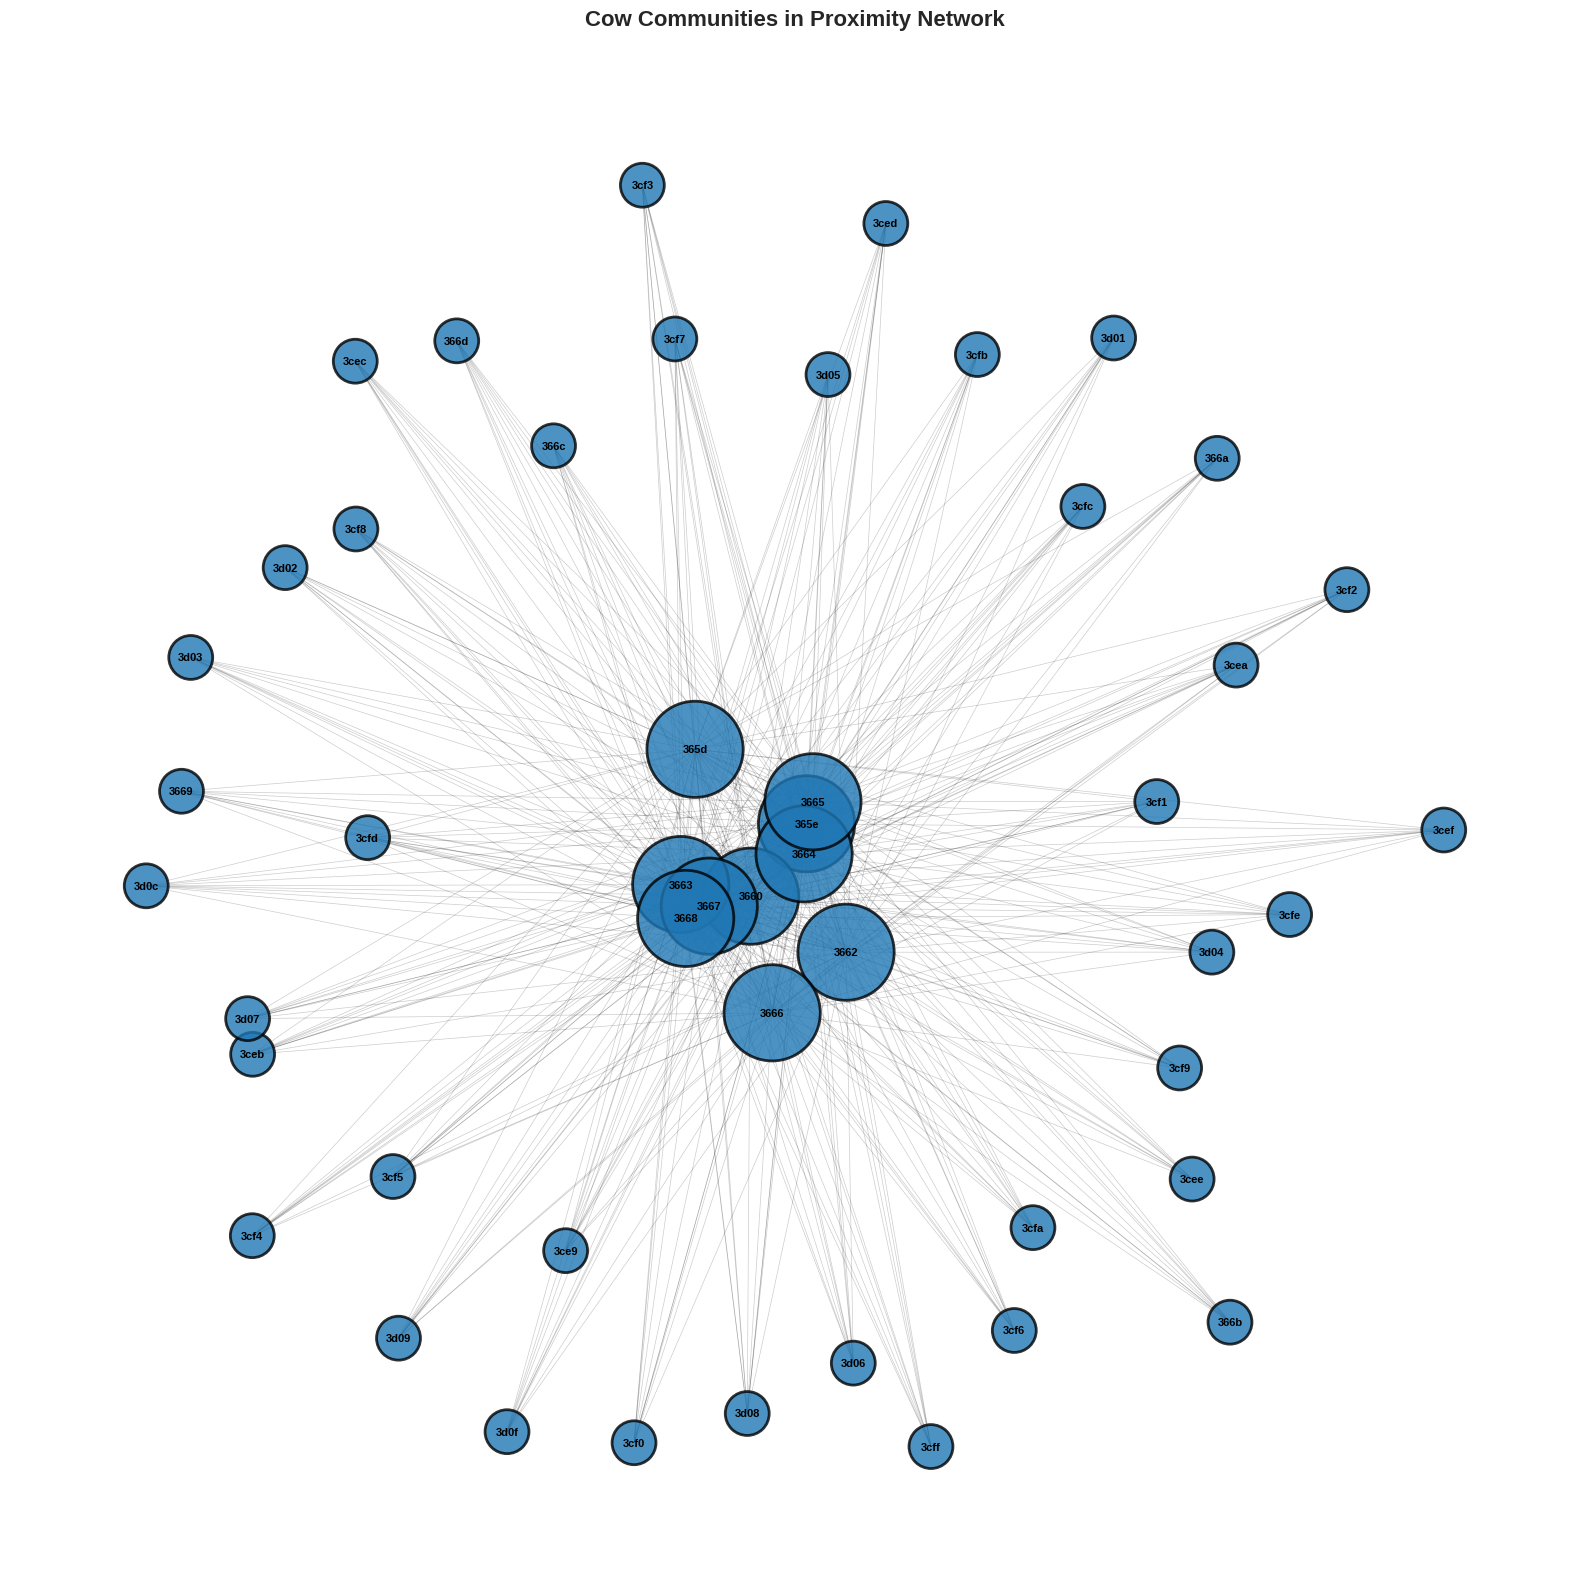

In [14]:
# Visualize communities
plt.figure(figsize=(16, 16))

# Assign colors to communities
colors = plt.cm.tab10(np.linspace(0, 1, len(communities)))
node_colors = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_colors[node] = colors[i]

node_color_list = [node_colors[node] for node in G.nodes()]

# Draw
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_color_list, 
                       edgecolors='black', linewidths=2, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title('Cow Communities in Proximity Network', fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

## 8. Temporal Network Evolution

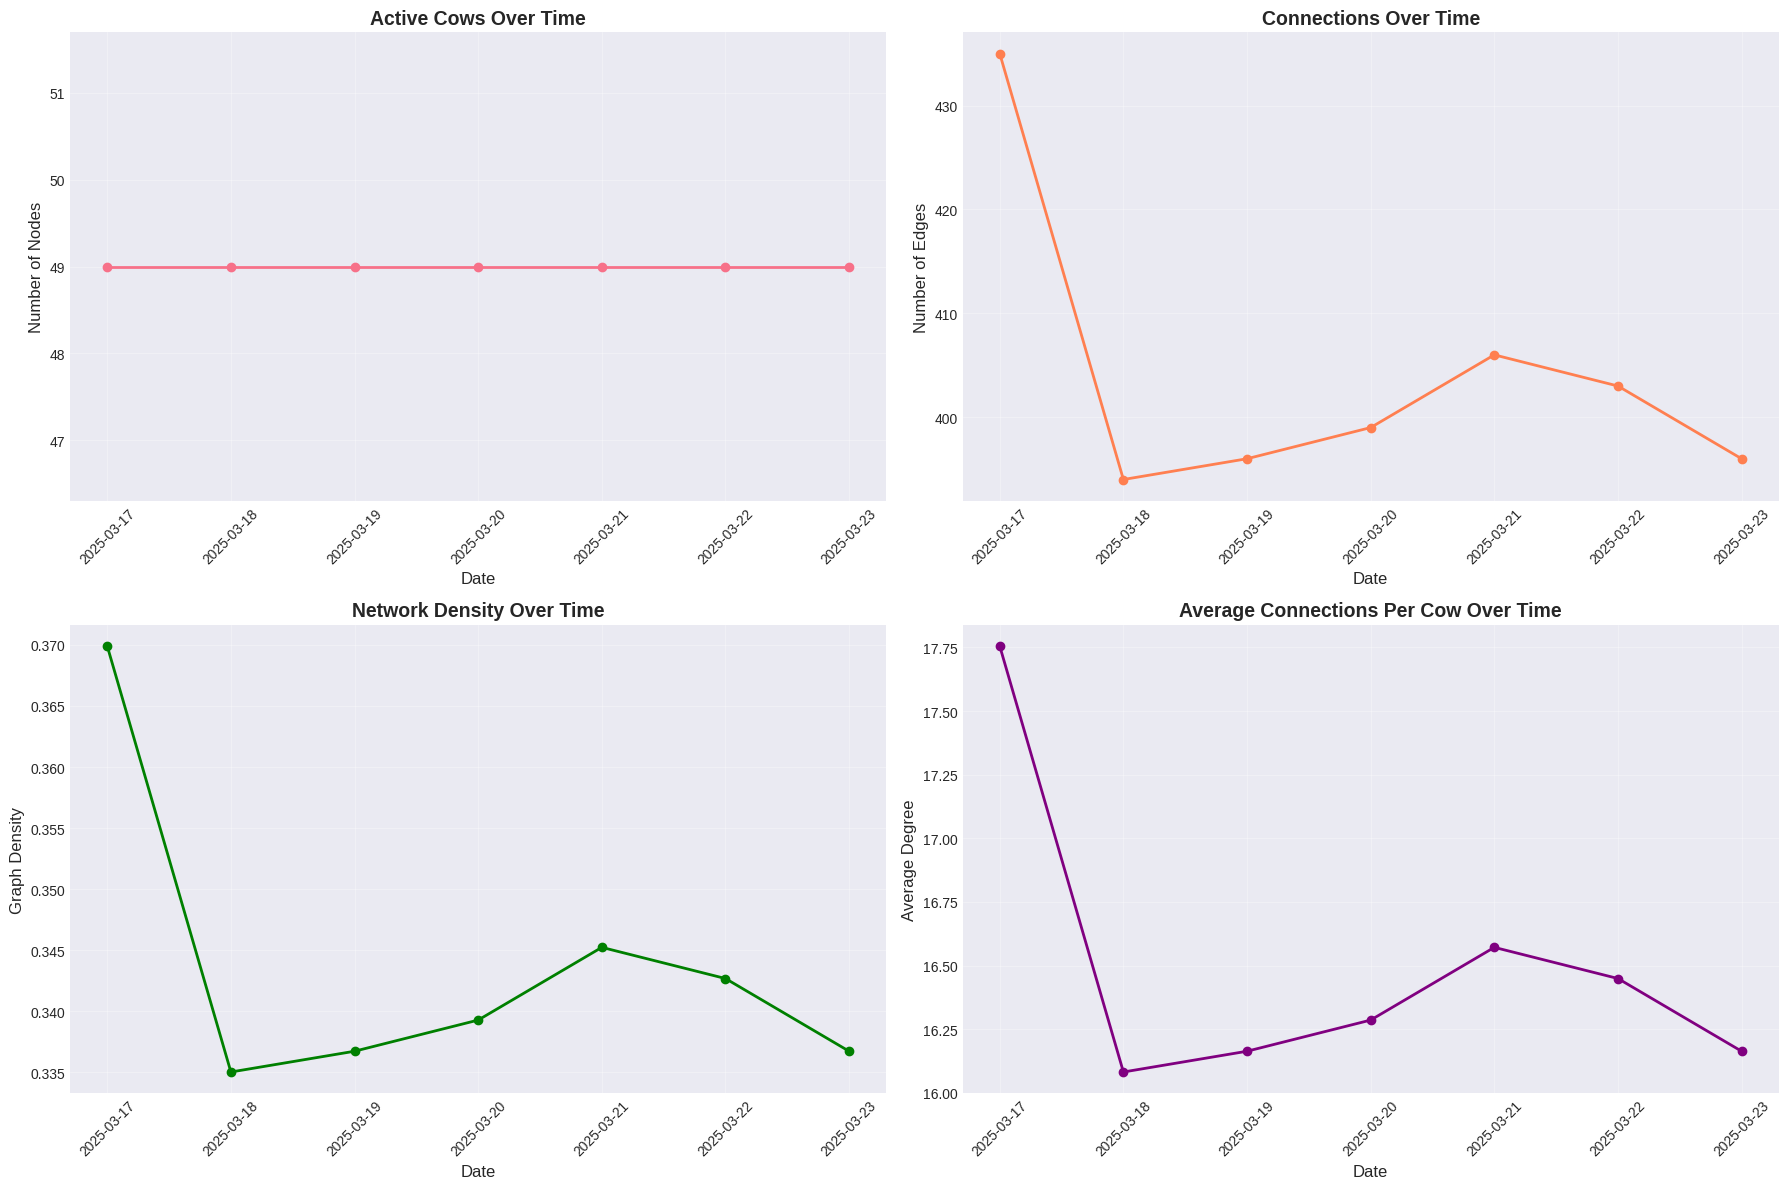

In [15]:
# Analyze how network changes over days
daily_graphs = {}
daily_stats = []

for date in sorted(rssi_df['date'].unique()):
    day_df = rssi_df[rssi_df['date'] == date]
    G_day, _ = create_proximity_graph(day_df, rssi_threshold=-70)
    daily_graphs[date] = G_day
    
    daily_stats.append({
        'date': date,
        'nodes': G_day.number_of_nodes(),
        'edges': G_day.number_of_edges(),
        'density': nx.density(G_day),
        'avg_degree': sum(dict(G_day.degree()).values()) / G_day.number_of_nodes() if G_day.number_of_nodes() > 0 else 0
    })

daily_stats_df = pd.DataFrame(daily_stats)

# Plot temporal evolution
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

axes[0, 0].plot(daily_stats_df['date'], daily_stats_df['nodes'], marker='o', linewidth=2)
axes[0, 0].set_xlabel('Date', fontsize=12)
axes[0, 0].set_ylabel('Number of Nodes', fontsize=12)
axes[0, 0].set_title('Active Cows Over Time', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(daily_stats_df['date'], daily_stats_df['edges'], marker='o', linewidth=2, color='coral')
axes[0, 1].set_xlabel('Date', fontsize=12)
axes[0, 1].set_ylabel('Number of Edges', fontsize=12)
axes[0, 1].set_title('Connections Over Time', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(daily_stats_df['date'], daily_stats_df['density'], marker='o', linewidth=2, color='green')
axes[1, 0].set_xlabel('Date', fontsize=12)
axes[1, 0].set_ylabel('Graph Density', fontsize=12)
axes[1, 0].set_title('Network Density Over Time', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(daily_stats_df['date'], daily_stats_df['avg_degree'], marker='o', linewidth=2, color='purple')
axes[1, 1].set_xlabel('Date', fontsize=12)
axes[1, 1].set_ylabel('Average Degree', fontsize=12)
axes[1, 1].set_title('Average Connections Per Cow Over Time', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary Statistics

In [16]:
print("="*70)
print("RSSI & PROXIMITY GRAPH SUMMARY")
print("="*70)

print("\n📊 RSSI DATA:")
print(f"  Total measurements: {len(rssi_df):,}")
print(f"  Time range: {rssi_df['relative_DateTime'].min()} to {rssi_df['relative_DateTime'].max()}")
print(f"  Duration: {(rssi_df['relative_DateTime'].max() - rssi_df['relative_DateTime'].min()).days} days")
print(f"  Unique cows (receivers): {rssi_df['receiver_id'].nunique()}")
print(f"  Unique cows (emitters): {rssi_df['emitter_id'].nunique()}")
print(f"  RSSI range: {rssi_df['RSSI'].min():.1f} to {rssi_df['RSSI'].max():.1f} dBm")
print(f"  Mean RSSI: {rssi_df['RSSI'].mean():.1f} dBm")
print(f"  Median RSSI: {rssi_df['RSSI'].median():.1f} dBm")

print("\n🔗 PROXIMITY GRAPH (RSSI >= -70 dBm):")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Density: {nx.density(G):.4f}")
print(f"  Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"  Average clustering: {nx.average_clustering(G):.4f}")
print(f"  Number of communities: {len(communities)}")

print("\n⏰ TEMPORAL PATTERNS:")
print(f"  Peak hour: {hourly_counts.idxmax()}:00 ({hourly_counts.max():,} measurements)")
print(f"  Most active day: {rssi_df.groupby('date').size().idxmax()} ({rssi_df.groupby('date').size().max():,} measurements)")

print("\n🐄 COW INTERACTIONS:")
print(f"  Most connected cow: {max(degrees.items(), key=lambda x: x[1])[0]} (degree: {max(degrees.values())})")
print(f"  Most frequent pair: {pair_counts.index[0]} ({pair_counts.values[0]:,} measurements)")

print("\n✅ Analysis complete!")

RSSI & PROXIMITY GRAPH SUMMARY

📊 RSSI DATA:
  Total measurements: 2,782,596
  Time range: 2025-03-17 00:00:00.062500 to 2025-03-23 23:59:58.750000
  Duration: 6 days
  Unique cows (receivers): 10
  Unique cows (emitters): 49
  RSSI range: -92.0 to -26.0 dBm
  Mean RSSI: -70.8 dBm
  Median RSSI: -77.0 dBm

🔗 PROXIMITY GRAPH (RSSI >= -70 dBm):
  Nodes: 49
  Edges: 435
  Density: 0.3699
  Average degree: 17.76
  Average clustering: 0.8659
  Number of communities: 1

⏰ TEMPORAL PATTERNS:
  Peak hour: 7:00 (165,194 measurements)
  Most active day: 2025-03-17 (958,218 measurements)

🐄 COW INTERACTIONS:
  Most connected cow: 365d (degree: 48)
  Most frequent pair: 3668 -> 3cfd (28,698 measurements)

✅ Analysis complete!


## 10. Export Summary

In [17]:
# Save summary statistics
summary = {
    'rssi_data': {
        'total_measurements': len(rssi_df),
        'unique_receivers': rssi_df['receiver_id'].nunique(),
        'unique_emitters': rssi_df['emitter_id'].nunique(),
        'rssi_mean': float(rssi_df['RSSI'].mean()),
        'rssi_median': float(rssi_df['RSSI'].median()),
        'rssi_min': float(rssi_df['RSSI'].min()),
        'rssi_max': float(rssi_df['RSSI'].max())
    },
    'proximity_graph': {
        'threshold': -70,
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': float(nx.density(G)),
        'avg_degree': float(sum(dict(G.degree()).values()) / G.number_of_nodes()),
        'avg_clustering': float(nx.average_clustering(G)),
        'num_communities': len(communities)
    }
}

import json
with open('rssi_proximity_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("✅ Summary saved to rssi_proximity_summary.json")

✅ Summary saved to rssi_proximity_summary.json
